In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from math import sqrt
import analyze
from itertools import chain

/Users/steve/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
f = open('data/time_series_covid19_deaths_global.csv')
reader = csv.reader(f)
first = True
rows = []

num_cols = 62
def default():
  return np.zeros(shape=(num_cols,))
province_counts = defaultdict(default)
agg_counts = defaultdict(default)
region_counts = defaultdict(default)
us_counts = defaultdict(default)
for row in reader:
  if first:
    columns = row
    first = False
  else:
    rows.append(row)
    series = np.array(list(map(float, row[4:])))
    if row[0] == '':
      region_counts[row[1]] = series
    else:
      province_counts[row[0]] = series
      agg_counts[row[1]] += series
# for US data
f = open('data/time_series_19-covid-Deaths.csv')
reader = csv.reader(f)
first = True
for row in reader:
  if first:
    first = False
  else:
    if row[1] == 'US' and row[0] != 'US' and row[0][-4] != ',':
      if row[-1] == '':
        row[-1] = -1
      series = np.array(list(map(float, row[4:])))
      us_counts[row[0]] = series
f = open('data/us_mar23.csv')
reader = csv.reader(f)
for row in reader:
  count = row[3]
  if count == '':
    count = -1
  us_counts[row[0]][-1] = int(count)

In [15]:
def calculate_growth(series, thresh=10, start=5):
  days = np.arange(0, series.shape[0])
  if ((series < thresh).all()):
    return None
  keep = series >= start
  series = series[keep]
  days = days[keep]
  if (days.shape[0] < 5):
    return None
  print(series)
  print(days)
  model = analyze.ExponentialGrowthRateEstimator(family='NegativeBinomial', alpha=0.1)
  model.fit(day=days, cases=series)
  print(np.diff(series))
  print(model.fitted_glm.mu)
  est = model.growth_rate()
  low, high = model.growth_rate_confint()
  return (max(low, 0), est, high)

In [16]:
growths = dict()
dataset = region_counts.items()
for k, v in dataset:
  #try:
  growth = calculate_growth(v, thresh = 50, start = 5)
  if growth:
    print(' (for %s)' % k)
    growths[k] = growth
  #except Exception:
  #  print('Failed to calculate for %s' % k)

[ 5. 10. 14. 21. 37. 67. 75. 88.]
[54 55 56 57 58 59 60 61]
[ 5.  4.  7. 16. 30.  8. 13.]
[ 6.005146    7.36300963  9.02790887 11.06926959 13.572216   16.64112032
 20.40395507]
 (for Belgium)
[  6.   9.  11.  19.  19.  33.  48.  48.  79.  91.  91. 148. 148. 148.
 243. 450. 562. 674. 860.]
[43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[  3.   2.   8.   0.  14.  15.   0.  31.  12.   0.  57.   0.   0.  95.
 207. 112. 112. 186.]
[  2.52160792   3.25034041   4.18967307   5.40046833   6.96117756
   8.97292421  11.56605592  14.90859014  19.21710059  24.77074973
  31.92937661  41.15681204  53.05093168  68.38239438  88.14457565
 113.61793174 146.45296454 188.77716304]
 (for France)
[  7.   9.  11.  17.  24.  28.  44.  67.  84.  94. 123.]
[51 52 53 54 55 56 57 58 59 60 61]
[ 2.  2.  6.  7.  4. 16. 23. 17. 10. 29.]
[ 2.89637578  3.73947135  4.82798057  6.23334     8.04778043 10.39037978
 13.41487792 17.31976629 22.36131453 28.87038884]
 (for Germany)
[   5.    8.   12.   16.   19.   

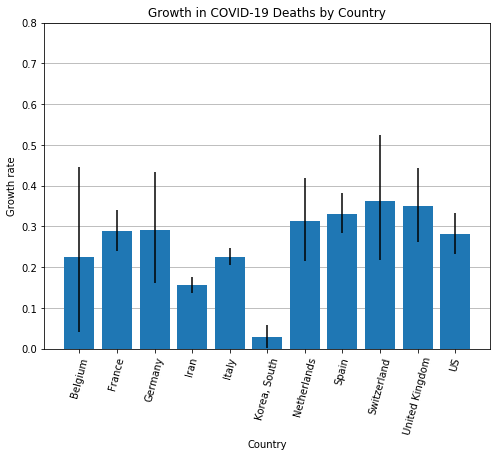

In [17]:
to_plot = growths
names = list(to_plot.keys())
err_l = list([v[1]-v[0] for v in to_plot.values()])
ests  = list([v[1] for v in to_plot.values()])
err_h = list([v[2]-v[1] for v in to_plot.values()])
errs = np.array([err_l, err_h])
plt.rcParams['axes.axisbelow'] = True
plt.bar(range(len(names)), ests, yerr=errs, align='center')
plt.ylim([0,0.8])
plt.grid(axis='y')
plt.xlabel('Country')
plt.xticks(rotation=75)
plt.ylabel('Growth rate')
plt.title('Growth in COVID-19 Deaths by Country')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)


plt.xticks(range(len(names)), names)
plt.show()